In [1]:
import comet_ml

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
device = torch.device("cuda", 2)

In [2]:
import numpy as np
import scipy
import scipy.stats
from numpy import trapz
import matplotlib.pyplot as plt
%matplotlib inline
NOISE_DIM = 5
DELTA=1
def sample_noise(N):
    return np.random.uniform(size=(N,NOISE_DIM)).astype(np.float32)

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, num_common_layers=3, num_heads_layers=2,
                 hidden_dim=100, input_param=1, activation_func=torch.tanh):
        
        super(Generator, self).__init__()
        self.activation_func = activation_func
        # body
        self.fc = []
        for i in range(num_common_layers):
            dim = noise_dim if i==0 else hidden_dim
            self.fc.append(nn.Linear(dim + input_param, hidden_dim))
            nn.init.xavier_normal_(self.fc[-1].weight)
            nn.init.constant_(self.fc[-1].bias, 0.0)
            
        self.fc  = nn.ModuleList(self.fc)
            
        # heads
        self.heads1 = []
        for i in range(num_heads_layers):
            dim = out_dim if i == num_heads_layers-1 else hidden_dim
            self.heads1.append(nn.Linear(hidden_dim + input_param, dim))
            nn.init.xavier_normal_(self.heads1[-1].weight)
            nn.init.constant_(self.heads1[-1].bias, 0.0)
            
        self.heads1  = nn.ModuleList(self.heads1)
            
        self.heads2 = []
        for i in range(num_heads_layers):
            dim = out_dim if i == num_heads_layers-1 else hidden_dim
            self.heads2.append(nn.Linear(hidden_dim + input_param, dim))
            nn.init.xavier_normal_(self.heads2[-1].weight)
            nn.init.constant_(self.heads2[-1].bias, 0.0)
            
        self.heads2  = nn.ModuleList(self.heads2)

    def forward(self, z, params, mode):
        """
            Generator takes a vector of noise and produces sample
        """
        h = z
        for fc in self.fc:
            h = self.activation_func(fc(torch.cat([h, params], dim=1)))
        
        heads = self.heads1 if mode=="01" else self.heads2
        for i, head in enumerate(heads):
            h = head(torch.cat([h, params], dim=1))
            if i < len(heads)-1:
                h = self.activation_func(h)
        
        return h

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, num_layers=5, hidden_dim=100, input_param=1):
        super(Discriminator, self).__init__()
        
        self.fc = []
        for i in range(num_layers):
            dim =in_dim if i==0 else hidden_dim
            out_dim = 1 if i==num_layers-1 else hidden_dim
            self.fc.append(nn.Linear(dim + input_param, out_dim))
            nn.init.xavier_normal_(self.fc[-1].weight)
            nn.init.constant_(self.fc[-1].bias, 0.0)
            
        self.fc  = nn.ModuleList(self.fc)
        
    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        h = x
        for i, fc in enumerate(self.fc):
            if i < len(self.fc)-3:
                h = torch.tanh(fc(torch.cat([h, params], dim=1)))
            elif i < len(self.fc)-1:
                h = F.leaky_relu(fc(torch.cat([h, params], dim=1)))
            else:
                h = fc(torch.cat([h, params], dim=1))
                
        return h

In [5]:
def g_loss(discrim_output):
    loss = - discrim_output.mean()
    return loss


def d_loss(discrim_output_gen, discrim_output_real):
    loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
    return loss

In [6]:
def generate_input(uniform_bounds, uniform_dim, normal_dim, batches, delta=0):
    alpha = np.random.uniform(*uniform_bounds, size=uniform_dim)
    return alpha, np.array([np.random.normal(alpha, 1, size=normal_dim) for i in range(batches)]) + delta

def generate_data(bounds, batch_size=256, batches_per_alpha=1, num=100000, delta=0):
    alphas = []
    datas = []

    for i in range(num):
        alpha, data = generate_input(bounds, 1, batch_size, batches_per_alpha, delta=delta)
        for d in data:
            alphas.append([alpha]*batch_size)
            datas.append(d.reshape(-1, 1))

    return np.array(alphas), np.array(datas)

In [7]:
# # [0, 1]
# batch_alpha_01, batch_data_01 = generate_data([0, 1])
# np.save("./two_head_gan_data/alpha_01_delta_1_train", batch_alpha_01)
# np.save("./two_head_gan_data/data_01_delta_1_train", batch_data_01)

# valid_alpha_01, valid_data_01 = generate_data([0, 1], batch_size=1024, num=1000)
# np.save("./two_head_gan_data/alpha_01_delta_1_val", valid_alpha_01)
# np.save("./two_head_gan_data/data_01_delta_1_val", valid_data_01)

# [0, 2]
# batch_alpha_02, batch_data_02 = generate_data([0, 2], delta=2)
# np.save("./two_head_gan_data/alpha_02_delta_2_train", batch_alpha_02)
# np.save("./two_head_gan_data/data_02_delta_2_train", batch_data_02)

# valid_alpha_02, valid_data_02 = generate_data([0, 2], batch_size=1024, num=1000, delta=2)
# np.save("./two_head_gan_data/alpha_02_delta_2_val", valid_alpha_02)
# np.save("./two_head_gan_data/data_02_delta_2_val", valid_data_02)

# # [1, 2]
# alpha_12, data_12 = generate_data([1, 2], batch_size=1024, num=1000)
# np.save("./two_head_gan_data/alpha_12_delta_1_val", alpha_12)
# np.save("./two_head_gan_data/data_12_delta_1_val", data_12)

In [8]:
# # alphas, digits from normal distbution for alpha \in [0,1]
batch_alpha_01, batch_data_01 = np.load("./two_head_gan_data/alpha_01_train.npy"), np.load("./two_head_gan_data/data_01_train.npy")
valid_alpha_01, valid_data_01 = np.load("./two_head_gan_data/alpha_01_val.npy"), np.load("./two_head_gan_data/data_01_val.npy")

# # alphas, digits from normal distbution for alpha \in [0,2]
batch_alpha_02, batch_data_02 = np.load("./two_head_gan_data/alpha_02_delta_{}_train.npy".format(DELTA)), np.load("./two_head_gan_data/data_02_delta_{}_train.npy".format(DELTA))
valid_alpha_02, valid_data_02 = np.load("./two_head_gan_data/alpha_02_delta_{}_val.npy".format(DELTA)), np.load("./two_head_gan_data/data_02_delta_{}_val.npy".format(DELTA))

# # alphas, digits from normal distbution for alpha \in [1,2]
alpha_12 = np.load("./two_head_gan_data/alpha_12_val.npy")
data_12 = np.load("./two_head_gan_data/data_12_val.npy")

In [9]:
batch_alpha_01.shape, batch_data_01.shape

((100000, 256, 1), (100000, 256, 1))

In [10]:
batch_alpha_02[0].mean()

0.2946412005001705

In [11]:
batch_data_02[0].mean()

1.2827554131262153

In [12]:
def iterate_minibatches(batch_alpha, batch_data):
    rp = np.random.permutation(len(batch_alpha))
    for x, y in zip(batch_alpha[rp], batch_data[rp]):
        yield torch.Tensor(x.reshape((len(x), 1))).to(device), torch.Tensor(y).to(device)

# def iterate_minibatches(batch_alpha, batch_data, batch_size=128):
#     batch_alpha = batch_alpha.reshape(-1, 1)
#     batch_data = batch_data.reshape(-1, 1)
    
#     rp = np.random.permutation(len(batch_alpha))
#     batch_alpha = batch_alpha[rp]
#     batch_data = batch_data[rp]
#     for i in range(0, len(batch_alpha), batch_size):
#         yield torch.Tensor(batch_alpha[i: i+batch_size]).to(device), torch.Tensor(batch_data[i: i+batch_size]).to(device)

In [13]:
fixed_noise = torch.Tensor(sample_noise(10000)).to(device)

In [14]:
from IPython import display
num_epochs = 5

dis_losses, gen_losses = {"01": [], "02": [], "12": []}, {"01": [], "02": [], "12": []}
wasserstein_ds = {"01": [], "02": [], "12": []}

def run_training(num_iters=50000):
    
    k_d, k_g = 4, 1
    
    def update_gen(input_alpha, input_data, mode, k_g):
        for _ in range(k_g):
            # Sample noise
            noise = torch.Tensor(sample_noise(len(input_data))).to(device)

            # Do an update
            data_gen = generator(noise, input_alpha, mode=mode)
            loss = g_loss(discriminator(data_gen, input_alpha))
            g_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()

        return loss.item()

    def update_disc(input_alpha, input_data, mode, k_d):
        for _ in range(k_d):
            # Sample noise
            noise = torch.Tensor(sample_noise(len(input_data))).to(device)

            # Do an update
            inp_data = input_data.to(device)
            data_gen = generator(noise, input_alpha, mode=mode)

    #         loss = d_loss(discriminator(data_gen, input_alpha), discriminator(inp_data, input_alpha))
    #         d_optimizer.zero_grad()
    #         loss.backward()
    #         d_optimizer.step()
    #         grad_penalty = calc_gradient_penalty(data_gen.data, inp_data.data, input_alpha)
    #         loss += grad_penalty

            loss1 = discriminator(data_gen, input_alpha).mean()

            d_optimizer.zero_grad()
            loss1.backward()
            d_optimizer.step()

            loss2 = -discriminator(inp_data, input_alpha).mean()

            d_optimizer.zero_grad()
            loss2.backward()
            d_optimizer.step()

            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

        return loss1.item() + loss2.item()

    
    step=500
    try:
        for epoch in range(num_epochs):
            dis_epoch_loss = {"01": [], "02": [], "12": []}
            gen_epoch_loss = {"01": [], "02": [], "12": []}
            
            train_gen_01 = iterate_minibatches(batch_alpha_01, batch_data_01)
            train_gen_02 = iterate_minibatches(batch_alpha_02, batch_data_02)
                        
            num_iter = 0
            while True:
                num_iter += 1
                try:
                    input_alpha, input_data = next(train_gen_01)
                except StopIteration:
                    break
                    
                # Optimize D
                dis_epoch_loss["01"].append(update_disc(input_alpha, input_data, "01", k_d))

                # Optimize G
                gen_epoch_loss["01"].append(update_gen(input_alpha, input_data, "01", k_g))
                
                try:
                    input_alpha, input_data = next(train_gen_02)
                except StopIteration:
                    break
                    
                # Optimize D
                dis_epoch_loss["02"].append(update_disc(input_alpha, input_data, "02", k_d))

                # Optimize G
                gen_epoch_loss["02"].append(update_gen(input_alpha, input_data, "02", k_g))
                
                
                if num_iter % step == 0:
                    
                    ws = []
                    for alpha, batch in zip(valid_alpha_01[:100], valid_data_01[:100]):
                        bs = len(alpha)
                        alpha = torch.Tensor(alpha).to(device)
                        noise = torch.Tensor(sample_noise(bs)).to(device)
                        generated = generator(noise, alpha, mode="01").detach().cpu().numpy()
                        ws.append(scipy.stats.wasserstein_distance(np.squeeze(generated), np.squeeze(batch)))
                    wasserstein_ds["01"].append(np.mean(ws))
                    
                    ws = []
                    for alpha, batch in zip(valid_alpha_02[:100], valid_data_02[:100]):
                        bs = len(alpha)
                        
                        alpha = torch.Tensor(alpha).to(device)
                        noise = torch.Tensor(sample_noise(bs)).to(device)
                        generated = generator(noise, alpha, mode="02").detach().cpu().numpy()
                        ws.append(scipy.stats.wasserstein_distance(np.squeeze(generated), np.squeeze(batch)))
                    wasserstein_ds["02"].append(np.mean(ws))
                    
                    
                    for i in dis_losses:
                        dis_losses[i].append(np.mean(dis_epoch_loss[i]))
                    for i in gen_losses:
                        gen_losses[i].append(np.mean(gen_epoch_loss[i]))
                    # Visualize
                    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

                    alphas = torch.Tensor([np.random.uniform(0, 1)]*len(fixed_noise)).reshape(-1, 1).to(device)
                    alpha = alphas[0].detach().cpu().numpy()
                    data = np.random.normal(alpha, 1, len(fixed_noise))
                    generated = generator(fixed_noise, alphas, mode="01").detach().cpu().numpy()
                    #wasserstein_ds["01"].append(scipy.stats.wasserstein_distance(np.squeeze(generated), data))
                    ax1.hist(data, bins=100, normed=True, label='true');
                    ax1.hist(generated, bins=100, color='g', normed=True, alpha=0.5, label='gan');
                    ax1.set_title("gen 01, alpha " + str(alpha[0]))
                    ax1.grid()
                    ax1.legend()

                    alphas = torch.Tensor([np.random.uniform(0, 2)]*len(fixed_noise)).reshape(-1, 1).to(device)
                    alpha = alphas[0].detach().cpu().numpy()
                    data = np.random.normal(alpha, 1, len(fixed_noise)) + DELTA
                    generated = generator(fixed_noise, alphas, mode="02").detach().cpu().numpy()
                    #wasserstein_ds["02"].append(scipy.stats.wasserstein_distance(np.squeeze(generated), data))
                    ax2.hist(data, bins=100, normed=True, label='true');
                    ax2.hist(generated, bins=100, color='g', normed=True, alpha=0.5, label='gan');
                    ax2.set_title("gen 02, alpha " + str(alpha[0]))
                    ax2.grid()
                    ax2.legend()

                    f2, (ax3, ax5) = plt.subplots(1, 2, figsize=(16, 6))
                    ax3.plot(dis_losses["01"], label='d_loss_01', c='b')
                    ax3.plot(dis_losses["02"], label='d_loss_02', c='g')
                    ax3.set_title("epoch")
                    ax3.set_title("loss")
                    ax3.grid()
                    ax3.legend()

                    ax4 = ax3.twinx()
                    ax4.plot(gen_losses["01"], label='g_loss_01', c='r')
                    ax4.plot(gen_losses["02"], label='g_loss_02', c='y')
                    ax3.set_title("epoch")
                    ax3.set_title("loss")
                    ax4.grid()
                    ax4.legend()
                    
                    ax5.plot(wasserstein_ds["01"], label='d_loss_01', c='b')
                    ax5.plot(wasserstein_ds["02"], label='d_loss_02', c='g')
                    ax5.set_title("epoch")
                    ax5.set_title("wasserstein_distance")
                    ax5.grid()
                    ax5.legend()
                    
                    alphas = [torch.Tensor([x]*1000).reshape(-1, 1).to(device) for x in np.linspace(-2, 4, 500)]
    
                    noise = torch.Tensor(sample_noise(1000)).to(device)
                    generated_01 = [generator(noise, alpha, mode="01").detach().cpu().numpy().mean() for alpha in alphas]
                    generated_02 = [generator(noise, alpha, mode="02").detach().cpu().numpy().mean() for alpha in alphas]

                    f3, (ax6, ax7) = plt.subplots(1, 2, figsize=(16, 6))
                    ax6.plot(np.linspace(-2, 4, 500), generated_01, label="gen_01")
                    ax6.plot(np.linspace(-2, 4, 500), generated_02, label="gen_02")
                    ax6.set_title("means of generated samples UNIFORM")
                    ax6.grid()
#                     ax6.xlabel("alpha")
#                     ax6.ylabel("generated samples mean value")
                    ax6.legend()

                    noise = torch.Tensor(sample_noise(1000)).to(device)
                    generated_01 = [generator(noise, alpha, mode="01").detach().cpu().numpy() for alpha in alphas]
                    generated_02 = [generator(noise, alpha, mode="02").detach().cpu().numpy() for alpha in alphas]

                    w_distances_01 = [scipy.stats.wasserstein_distance(np.squeeze(g), np.random.normal(a, 1, len(g))) for g, a in zip(generated_01, np.linspace(-2, 4, 500))]
                    w_distances_02 = [scipy.stats.wasserstein_distance(np.squeeze(g), np.random.normal(a, 1, len(g))+DELTA) for g, a in zip(generated_02, np.linspace(-2, 4, 500))]

                    ax7.plot(np.linspace(-2, 4, 500), w_distances_01, label="gen_01")
                    ax7.plot(np.linspace(-2, 4, 500), w_distances_02, label="gen_02")
                    ax7.set_title("WDs bwn real and sampled UNIFORM")
                    ax7.grid()
#                     ax7.xlabel("alpha")
#                     ax7.ylabel("WD bwn real and sampled ")
                    ax7.legend()


                    display.clear_output(wait=True)
                    plt.show()
                    
                    if num_iter > 2*step and (wasserstein_ds["02"][-1] + wasserstein_ds["01"][-1]) < np.min(np.array(wasserstein_ds["02"][:-1])+np.array(wasserstein_ds["01"][:-1])):
                            torch.save(generator.state_dict(), "./models_test/ALL_generator_sd_delta_{}_diff_heads".format(DELTA))
                            torch.save(discriminator.state_dict(), "./models_test/ALL_discriminator_sd_{}_diff_heads".format(DELTA))

                            torch.save(generator, "./models_test/ALL_generator_{}_diff_heads".format(DELTA))
                            torch.save(discriminator, "./models_test/ALL_discriminator_{}_diff_heads".format(DELTA))
                    
                    if num_iter >= 10*step:
                            
                        if num_iter == 10*step or (wasserstein_ds["02"][-1] + wasserstein_ds["01"][-1]) < np.min(np.array(wasserstein_ds["02"][8:-1])+np.array(wasserstein_ds["01"][8:-1])):
                            torch.save(generator.state_dict(), "./models_test/generator_sd_{}_diff_heads".format(DELTA))
                            torch.save(discriminator.state_dict(), "./models_test/discriminator_sd_{}_diff_heads".format(DELTA))

                            torch.save(generator, "./models_test/generator_{}_diff_heads".format(DELTA))
                            torch.save(discriminator, "./models_test/discriminator_{}_diff_heads".format(DELTA))
                        
                    
#                     if num_iter > 21*step:
#                         min_before = np.min(np.array(wasserstein_ds["02"][20:-5])+np.array(wasserstein_ds["01"][20:-5]))
#                         min_after = np.min(np.array(wasserstein_ds["02"][-5:])+np.array(wasserstein_ds["01"][-5:]))

#                         if min_before - min_after < 0.01:
#                             break
                            
                    
#                 if num_iter >= num_iters:
#                     break

    except KeyboardInterrupt:
        pass

In [15]:
def get_disc_losses(mode, n_samples=1000):
    alphas = np.linspace(0, 2, 100)
    losses = {"real": [], "fake": [], "combined": []}
    for alpha in alphas:
        data = torch.Tensor(np.random.normal(alpha, 1, n_samples)).reshape(-1, 1).to(device)
        alpha = torch.Tensor([alpha]*n_samples).reshape(-1, 1).to(device)
        
        loss_real = discriminator(data, alpha).mean().item()
        losses["real"].append(loss_real)
        
        noise = torch.Tensor(sample_noise(n_samples)).to(device)
        generated = generator(noise, alpha, mode=mode)
        loss_fake = discriminator(generated, alpha).mean().item()
        losses["fake"].append(loss_fake)
        
        losses["combined"].append(loss_fake-loss_real)
    return losses

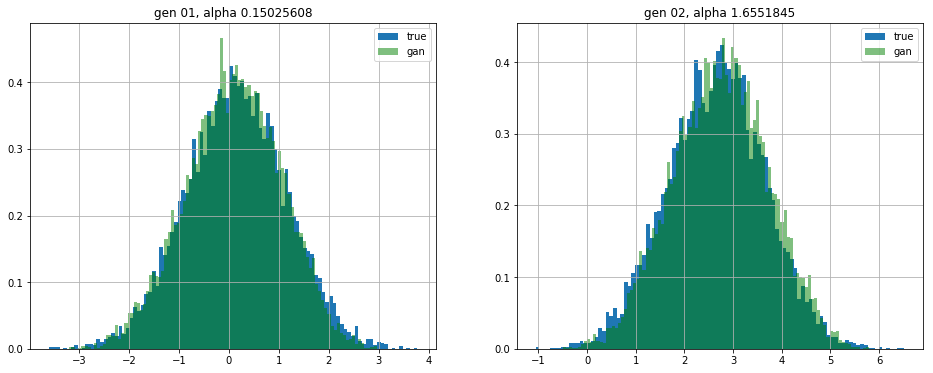

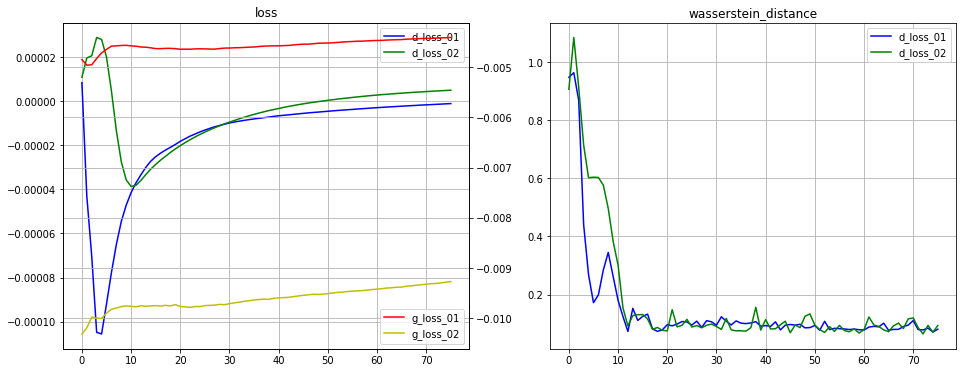

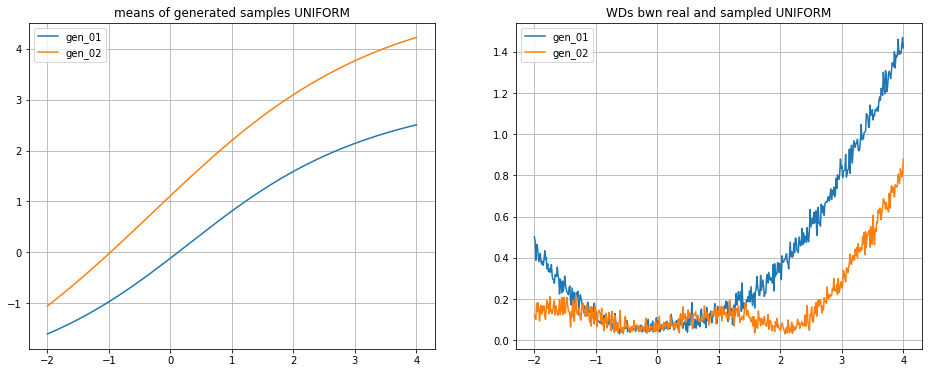

In [25]:
generator = Generator(NOISE_DIM, out_dim = 1, num_common_layers=2, 
                     num_heads_layers=1, hidden_dim=100,
                      activation_func=torch.tanh
                     ).to(device)
discriminator = Discriminator(in_dim = 1, num_layers=5, hidden_dim=100).to(device)

lr = 0.00001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

dis_losses, gen_losses = {"01": [], "02": [], "12": []}, {"01": [], "02": [], "12": []}
wasserstein_ds = {"01": [], "02": [], "12": []}

display.clear_output(wait=True)
run_training()